In [1]:
import os
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from python import prepare_inputs as pi
from python import solar_utils as su
from python import utils as pu

from python.utils import project_path

# Input data for a run

In [2]:
import importlib
importlib.reload(pi)

<module 'python.prepare_inputs' from '/home/fs01/dcl257/projects/acorn-julia/src/python/prepare_inputs.py'>

In [3]:
# Read GenX
df_genX = pd.read_csv(f'{project_path}/data/genX/capacity_Low_RE_High_Elec.csv')
df_genX = pi.tidy_genX(df_genX).query('EndCap > 1.')

In [4]:
df_genX.groupby('Resource')['StartCap'].sum()

Resource
battery                       0.0
biomass                     113.1
distributed_generation     2554.0
hydroelectric              5763.7
natural_gas               16458.8
nuclear                    2777.0
offshore_wind                 0.0
onshore_wind_existing      3389.0
solar_existing             1706.4
solar_new                     0.0
transportation             3407.1
water_heating               139.1
Name: StartCap, dtype: float64

In [5]:
df_genX.groupby('Resource')['EndCap'].sum()

Resource
battery                    5999.830098
biomass                     113.100000
distributed_generation     2553.999939
hydroelectric              5763.700000
natural_gas               16458.799831
nuclear                    2699.998583
offshore_wind              5737.998789
onshore_wind_existing      3388.999992
solar_existing             1706.399995
solar_new                 23133.293921
transportation             3407.100000
water_heating               139.100000
Name: EndCap, dtype: float64

In [6]:
# Read GenX downscaled
df_genX_ds = pd.read_csv(f'{project_path}/data/genX/selected_CPA_Combined_Capacity_Low_RE_High_Elec.csv')

df_genX_ds = (df_genX_ds[(df_genX_ds['state'] == 'New York') & (df_genX_ds['iter'] == 0)]
              .drop_duplicates(subset=['Resource', 'Zone'], keep='first')
              .query('EndCap > 1.')
             )

df_genX_ds.groupby('Resource_Type')['EndCap'].sum()

Resource_Type
Utility_PV    23133.29392
Name: EndCap, dtype: float64

In [7]:
# Run name (make sure matches above!)
run_name = "low_RE_high_elec_iter1_default"

run_path = f"{project_path}/runs/{run_name}"

Path(f"{run_path}/inputs").mkdir(parents=True, exist_ok=True)
Path(f"{run_path}/outputs").mkdir(parents=True, exist_ok=True)

### Thermal

In [37]:
# Read ACORN generators
df_genprop_bo = pd.read_csv(f'{project_path}/data/grid/gen_prop_boyuan.csv')
df_gencost_bo = pd.read_csv(f'{project_path}/data/grid/gencost_prop_boyuan.csv')

# Merge costs and info
df_genprop = pd.merge(df_gencost_bo, df_genprop_bo)

# Select NYS only
df_genprop = df_genprop[df_genprop['GEN_ZONE'].isin(pu.zone_names)]

In [38]:
# Match thermal capacities (natural gas)
df_genprop_matched = pi.match_ng_capacity(df_genX,
                                          df_genprop,
                                          print_path = run_path,
                                          retirement_method='highest_cost_first')

Starting capacity matching process...

Capacity comparison:
Zone | Current (MW) | Target (MW) | Difference (MW)
-------------------------------------------------------
A    |       393.0 |      536.8 |         143.8
Zone A: Added 3 duplicate generators, increasing capacity by 158.0 MW (target: 143.8 MW)
B    |       109.0 |      269.1 |         160.1
Zone B: Added 4 duplicate generators, increasing capacity by 195.0 MW (target: 160.1 MW)
C    |      1709.0 |     1672.9 |         -36.1
Zone C: Retired 1 generators, reducing capacity by 110.0 MW (target: 36.1 MW)
D    |       346.0 |      371.0 |          25.0
Zone D: Added 1 duplicate generators, increasing capacity by 142.0 MW (target: 25.0 MW)
E    |       206.0 |      201.6 |          -4.4
Zone E: Retired 1 generators, reducing capacity by 45.0 MW (target: 4.4 MW)
F    |      3159.0 |     3797.5 |         638.5
Zone F: Added 4 duplicate generators, increasing capacity by 690.0 MW (target: 638.5 MW)
G    |      1761.0 |     2015.0 |  

### Solar

In [57]:
# NOTE: there is some existing solar on the grid that we are neglecting currently, 
# in future we need to calculate time series for these and assign to buses 
# in the correct zone
df_genX[df_genX['Resource'] == 'solar_existing']

,Resource,Zone,StartCap,RetCap,NewCap,EndCap,StartEnergyCap,RetEnergyCap,NewEnergyCap,EndEnergyCap,StartChargeCap,RetChargeCap,NewChargeCap,EndChargeCap
311,solar_existing,A,144.7,7.113714e-07,0.0,144.699999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,solar_existing,B,170.7,6.948752e-07,0.0,170.699999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,solar_existing,C&E,701.8,1.237504e-06,0.0,701.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,solar_existing,D,70.8,8.859830e-07,0.0,70.799999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315,solar_existing,F,422.7,8.451464e-07,0.0,422.699999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,solar_existing,G-I,195.7,5.780801e-07,0.0,195.699999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


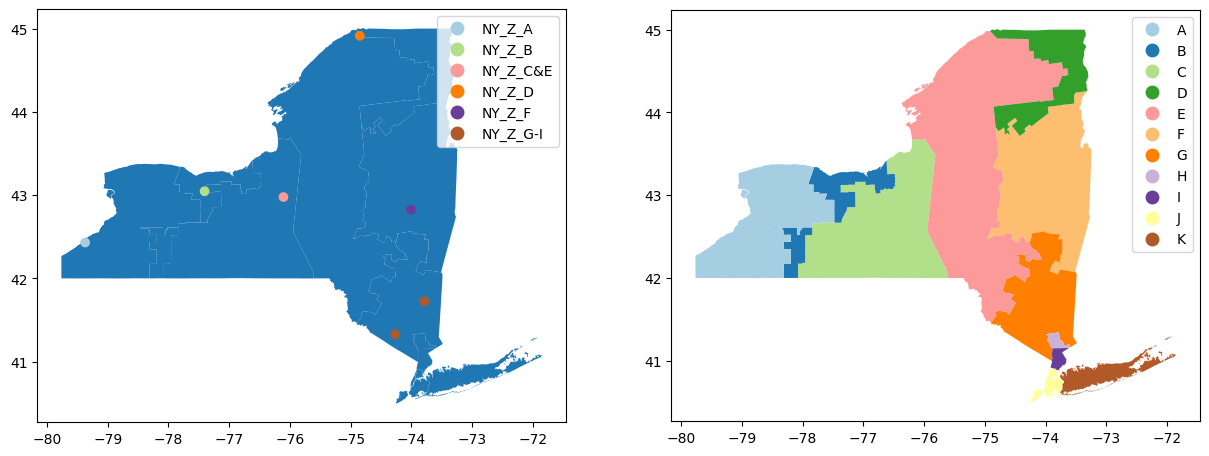

In [47]:
################################################################
# NOTE: The genX zones do not always align with their coordinates
# (i.e. they will be assigned to a different zone).
# When aggregating to bus level, assigning `match_zone` = True
# means that genX zones will be respected. `match_zone` = False
# means it will use the lat/lon coords instead.
################################################################
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# Plot
fig, axs = plt.subplots(1,2, figsize=(15,10))

nyiso_gdf.plot(ax=axs[0])
pu.merge_to_zones(df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'],
               lat_name='latitude',
               lon_name='longitude').plot(ax=axs[0], column='region', legend=True, cmap='Paired')

nyiso_gdf.plot(ax=axs[1], column='zone', legend=True, cmap='Paired')

plt.show()

In [49]:
# Update the genX regions
df_genX_ds_solar = df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'].copy()
df_genX_ds_solar = pu.map_genX_zones_to_nyiso(df_genX_ds_solar, C_and_E_mapping='C')

In [50]:
# Calculate timeseries
# TGW climate data
climate_scenario = "historical_1980_2019"

# climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1985)]).flatten()

# Correction factors
correction_file = f"{project_path}/data/solar/models/tgw_solar_correction_factors.csv"

# Calculate the timeseries
df_solar = su.calculate_solar_timeseries_from_genX(
    df_genX = df_genX_ds_solar,
    climate_paths = climate_paths,
    correction_file = correction_file,
)
# Store
df_solar.reset_index().pivot(index='bus_id', 
                             columns='datetime', 
                             values='power_MW').to_csv(f"{run_path}/inputs/solar_upv_{climate_scenario}.csv")

### Wind

In [12]:
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

In [13]:
# NOTE: there is existing wind on the grid that we need to calculate 
# and assign to buses in the correct zone
df_genX[df_genX['Resource'] == 'onshore_wind_existing']

,Resource,Zone,StartCap,RetCap,NewCap,EndCap,StartEnergyCap,RetEnergyCap,NewEnergyCap,EndEnergyCap,StartChargeCap,RetChargeCap,NewChargeCap,EndChargeCap
285,onshore_wind_existing,A,446.9,0.000001,0.0,446.899999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,onshore_wind_existing,B,341.2,0.000002,0.0,341.199998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,onshore_wind_existing,C&E,1922.4,0.000003,0.0,1922.399997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288,onshore_wind_existing,D,678.5,0.000001,0.0,678.499999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# NOTE: there is existing wind on the grid that we need to calculate 
# and assign to buses in the correct zone
df_genX[df_genX['Resource'] == 'offshore_wind']

,Resource,Zone,StartCap,RetCap,NewCap,EndCap,StartEnergyCap,RetEnergyCap,NewEnergyCap,EndEnergyCap,StartChargeCap,RetChargeCap,NewChargeCap,EndChargeCap
242,offshore_wind,J,0.0,0.0,422.499988,422.499988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,offshore_wind,J,0.0,0.0,121.199998,121.199998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,offshore_wind,J,0.0,0.0,388.799918,388.799918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,offshore_wind,J,0.0,0.0,198.799998,198.799998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,offshore_wind,J,0.0,0.0,371.199971,371.199971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,offshore_wind,J,0.0,0.0,113.799996,113.799996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266,offshore_wind,J,0.0,0.0,694.999987,694.999987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,offshore_wind,J,0.0,0.0,808.799987,808.799987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,offshore_wind,J,0.0,0.0,1033.599975,1033.599975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,offshore_wind,J,0.0,0.0,154.099129,154.099129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


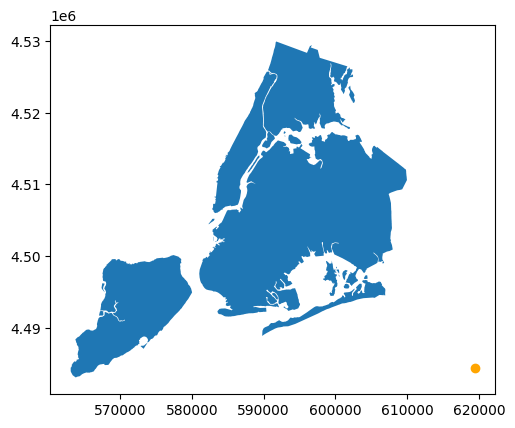

In [97]:
fig, ax = plt.subplots()

nyiso_gdf.query('zone == "J"').to_crs("EPSG:32618").plot(ax=ax)
generate_offshore_wind_sites('J', nyiso_gdf, 1).plot(ax=ax, color='orange')

plt.show()

In [ ]:
################################################################
# NOTE: The genX zones do not always align with their coordinates
# (i.e. they will be assigned to a different zone).
# When aggregating to bus level, assigning `match_zone` = True
# means that genX zones will be respected. `match_zone` = False
# means it will use the lat/lon coords instead.
################################################################
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{project_path}/data/nyiso/gis/NYISO_Load_Zone_Dissolved.shp')

# Plot
fig, axs = plt.subplots(1,2, figsize=(15,10))

nyiso_gdf.plot(ax=axs[0])
pu.merge_to_zones(df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'],
               lat_name='latitude',
               lon_name='longitude').plot(ax=axs[0], column='region', legend=True, cmap='Paired')

nyiso_gdf.plot(ax=axs[1], column='zone', legend=True, cmap='Paired')

plt.show()

In [ ]:
# Update the genX regions
df_genX_ds_wind = df_genX_ds[df_genX_ds['Resource_Type'] == 'Utility_PV'].copy()
df_genX_ds_wind = pu.map_genX_zones_to_nyiso(df_genX_ds_solar, C_and_E_mapping='C')

In [ ]:
# Calculate timeseries
# TGW climate data
climate_scenario = "historical_1980_2019"

climate_paths = np.sort(glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_*.nc"))
climate_paths = np.sort([glob(f"{pu.tgw_path}/{climate_scenario}/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1985)]).flatten()

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/models/tgw_wind_stability_coefficients.csv"

# Calculate the timeseries
df_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_sel,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'iec1',
)